In [1]:
using DataFrames, CSV
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots, GRUtils
using Distributions
using Gurobi, JuMP

In [2]:
# Constants
N = 3 ; # number of passengers
K = 3 ;  # number of shuttles

In [3]:
# Use this cost later to load costs from BingsMap. For now, we will simply use the euclidian distance as shown below.
c = Matrix(DataFrame(CSV.File("../SimulatedCosts.csv")))
c = c[:, 2:size(c)[2]];

t = c  #let's consider in this initial model that the travel cost and the time and equivalent. 

8×8 Matrix{Float64}:
 1.2  4.0  1.2  4.5  1.2  0.9  1.2   0.9
 3.0  3.0  3.2  1.4  1.6  0.6  0.7   0.5
 1.4  5.0  4.6  1.9  3.8  3.0  0.4   0.2
 1.9  2.0  1.9  2.5  2.5  5.0  1.8   1.5
 2.5  1.0  2.4  1.2  6.2  2.0  1.3   1.7
 1.2  5.0  1.9  4.0  4.5  1.2  0.9   1.2
 4.0  2.0  2.5  2.0  2.1  2.4  6.5  18.3
 2.0  1.0  1.2  3.0  3.0  5.0  4.6   1.9

In [4]:
# Data
data = Matrix(DataFrame(CSV.File("../SimulatedDataTest.csv")));

q = data[1:2*N+2, 4];
d = data[1:2*N+2, 5];
e = data[1:2*N+2, 7];
l = data[1:2*N+2, 8];

#compute costs/time as euclidian distance.
c = zeros(2 * N + 2, 2 * N + 2)
for i = 1:2*N+2
    for j = 1:2*N+2
        c[i, j] = norm(data[i, 2:3] - data[j, 2:3]) / 10
    end
end

t = c  #let's consider in this initial model that the travel cost and the time and equivalent. 

8×8 Matrix{Float64}:
 0.0       0.291247  0.150659  0.743121  …  0.693661  1.31528   0.0
 0.291247  0.0       0.326118  0.620831     0.488037  1.03742   0.291247
 0.150659  0.326118  0.0       0.869122     0.789801  1.28146   0.150659
 0.743121  0.620831  0.869122  0.0          0.238253  1.26881   0.743121
 0.668374  0.379722  0.697821  0.585946     0.353577  0.733003  0.668374
 0.693661  0.488037  0.789801  0.238253  …  0.0       1.03335   0.693661
 1.31528   1.03742   1.28146   1.26881      1.03335   0.0       1.31528
 0.0       0.291247  0.150659  0.743121     0.693661  1.31528   0.0

### The model

In [5]:
model = Model(Gurobi.Optimizer)

V = [1, 2, 3, 4, 5, 6, 7, 8]   # all vertices
P = [2, 3, 4]             # pick up vertices
D = [5, 6, 7]             # drop off vertices
PUD = [2, 3, 4, 5, 6, 7]     # all pick up and drop off vertices together (all vertices except depot)

T = [100, 100, 100]       # maximum duration of route k
L = 100                  # maximum time of a drive
Q = [3, 3, 3]             # capacity of each car

# Variables
@variable(model, x[1:2*N+2, 1:2*N+2, 1:K] >= 0, Bin)   # x[i, j, k] = 1 if we go from node i to node j with vehicle k.
@variable(model, w[1:2*N+2, 1:K] >= 0, Int)            # w[i,k] load of vehicle k when arriving upon leaving vertex i
@variable(model, r[1:N] >= 0)                          # r[i,k] travel time of passenger i (Note that passenger i is identified by) the vertex i+1

@variable(model, u[1:2*N+2, 1:K] >= 0)                 # u[i,k] time as which the vertex i is served by vehicle k

#############  Constraints  #############

# only one car can bring passenger {i, i+N} to its final destination.
@constraint(model, [i in P], sum(sum(x[i, j, k] for j in V) for k = 1:K) == 1)

# each vehicle starts at the depot
@constraint(model, [k = 1:K], sum(x[1, j, k] for j in V) == 1)

# each vehicle ends at the depot
@constraint(model, [k = 1:K], sum(x[i, 2*N+2, k] for i in V) == 1)

# each passenger is picked and droped by the same car
@constraint(model, [i in P, k = 1:K], sum(x[i, j, k] for j in V) - sum(x[i+N, j, k] for j in V) == 0)

# vehicle k follows the edges sequentially
@constraint(model, [i in PUD, k = 1:K], sum(x[j, i, k] for j in V) - sum(x[i, j, k] for j in V) == 0)

# PREVIOUS the time served of vertex i
@constraint(model, [i in V, j in V, k = 1:K], u[j, k] >= (u[i, k] + d[i] + t[i, j]) * x[i, j, k])

# updating the load of the vehicle
@constraint(model, [i in V, j in V, k = 1:K], w[j, k] >= (w[i, k] + q[j]) * x[i, j, k])

# updating the travel time of passenger i
@constraint(model, [i in P, k = 1:K], r[i-1] == u[N+i, k] - (u[i, k] + d[i]))

# respecting the total length of a trip
@constraint(model, [k = 1:K], u[2*N+2,k] - u[1,k] <= T[k])

# respecting travel window of passenger i
@constraint(model, [i in V, k = 1:K], e[i] <= u[i,k])
@constraint(model, [i in V, k = 1:K], u[i,k] <= l[i])

# respecting travel window of passenger i
@constraint(model, [i in P], t[i,i+N] <= r[i-1])
@constraint(model, [i in P], r[i-1] <= L)

# respecting each car's capacity
@constraint(model, [i in V, k = 1:K], max(0, q[i]) <= w[i, k])
@constraint(model, [i in V, k = 1:K], w[i, k] <= min(Q[k], Q[k] + q[i]))

# CORRECTION: ---> Let's try to fix the load problem: the load was not null for the useless cars. This was fixed.
# @constraint(model, [i in V, k = 1:K], sum(x[:,i,k])*q[i] <= w[i, k])
# @constraint(model, [i in V, k = 1:K], 0 <= w[i, k])

# @constraint(model, [i in V, k = 1:K], w[i, k] <= sum(x[:,i,k])*Q[k])
# @constraint(model, [i in V, k = 1:K], w[i, k] <= Q[k] + sum(x[:,i,k])*q[i])


### --- ADDITIONAL CONSTRAINTS -----

# Pick up before drop off
@constraint(model, [i=1:N+1, k=1:K], u[i,k] <= u[N+i,k])

# # No passengers at the beginning / end
# @constraint(model, [k = 1:K], w[1, k] == 0)
# @constraint(model, [k = 1:K], w[2*N+2, k] == 0)

# objective
@objective(model, Min, sum(sum(sum(c[i, j] * x[i, j, k] for k = 1:K) for i in V) for j in V));

# Objective with a penalty function in the ride time and on the load of each car
# @objective(model, Min, sum(sum(sum(c[i, j] * x[i, j, k] for k = 1:K) for i in V) for j in V) + sum(w) + sum(u) + sum(u_depot) + sum(x));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


In [6]:
optimize!(model)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 162 rows, 243 columns and 675 nonzeros
Model fingerprint: 0x02e889e5
Model has 384 quadratic constraints
Variable types: 27 continuous, 216 integer (192 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e-01, 3e+00]
  Objective range  [2e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+03]
Presolve added 87 rows and 0 columns
Presolve removed 0 rows and 63 columns
Presolve time: 0.01s
Presolved: 309 rows, 210 columns, 1344 nonzeros
Variable types: 33 continuous, 177 integer (135 binary)

Root relaxation: objective 3.114444e+00, 47 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0   

In [7]:
u_values = value.(u)

8×3 Matrix{Float64}:
 6.0       0.0       0.0
 2.0       4.77876   8.0
 4.0      10.0       4.0
 6.0       5.89959   6.0
 4.20678   6.98554  10.2068
 5.2898   11.2898    5.2898
 8.31895   8.21854   8.31895
 0.0      74.015     1.23614e-15

In [8]:
r_values = value.(r)

3-element Vector{Float64}:
 1.706777213665033
 0.7898006077485462
 1.818948596314804

In [9]:
w_values = round.(Int, value.(w))

8×3 Matrix{Int64}:
 0  0  0
 1  1  1
 3  3  3
 1  2  1
 0  1  0
 0  0  0
 0  0  0
 3  2  3

In [10]:
function plot_route(df, x_val, w_val, plot_size)
    
    # df: dataframe containing all the input data:
    #     column 1: Passenger ID
    #     column 2: PickUp/DropOff Pos_x
    #     column 3: PickUp/DropOff Pos_y
    #     column 4: load (number of passengers to embark)
    #     column 5: service duration (embark time)
    #     column 6: preferred pick up time
    #     column 7: lower bound of pick up time
    #     column 8: upper bound of pick up time

    # car_nbr: the vehicle number to plot

    # x_val: the values of x
    
    #constants 
    N = round(Int,(size(df)[1]-2)/2)

    cars_used = findall([sum(x_val[:,:,i]) for i=1:size(x_val)[3]] .> 2)
    print(cars_used)
    
    println("Number of cars used: $(sum(cars_used))")
    println("The car(s) used are(is): ", cars_used)


    # plot the depot
    Plots.scatter([df[1, 2]], [df[2*N+2, 3]], 
        size = (plot_size[1], plot_size[2]),
        titlefont=font(20, "Computer Modern"), 
        color="black", 
        markersize=5, 
        labels="Depot", 
        title="Result for different cars",  
        legend = :bottomright,
        format=:png)

    # plot all pick-up points
    for i=2:N+1
        pass_ID = round(Integer, df[i,1])

        Plots.scatter!([df[i, 2]], [df[i, 3]],
            color="lightgreen", 
            xlabel="x", ylabel="y",
            labels="PickUp ID: $pass_ID - $(data[i,4]) passenger(s)",  
            annotations = (df[i, 2], df[i, 3], Plots.text("  Pick:$pass_ID", :left, pointsize=10)),
            format=:png,
            markersize=5)

        Plots.scatter!([df[i+N, 2]], [df[i+N, 3]],
            color="red", 
            xlabel="x", ylabel="y",
            labels="DropOff ID: $pass_ID - $(data[i,4]) passenger(s)",  
            annotations = (df[i+N, 2], df[i+N, 3], Plots.text("  Drop:$pass_ID", :left, pointsize=10)),
            format=:png,
            markersize=5)
    end

    colors = ["black", "red", "green", "blue", "pink"]
    for car in cars_used
        for i in 1:2*N+2
            for j in 1:2*N+2
                if x_val[i, j, car] == 1
                    print(i, " ", j, " --> ")
                    Plots.plot!([df[i, 2], df[j, 2]], [df[i, 3], df[j, 3]], color=colors[car], labels="", textposition="bottom left", linewidth=1, arrow=true, arrowwidth=3, format=:png)
                end
            end
        end
    end

    # plot the depot
    Plots.scatter!([df[1, 2]], [df[2*N+2, 3]], 
        titlefont=font(20, "Computer Modern"), 
        color="black", 
        markersize=5, 
        labels="Depot", 
        format=:png)

end


plot_route (generic function with 1 method)

[2]Number of cars used: 2
The car(s) used are(is): [2]
1 2 --> 2 4 --> 3 6 --> 4 5 --> 5 7 --> 7 3 --> 

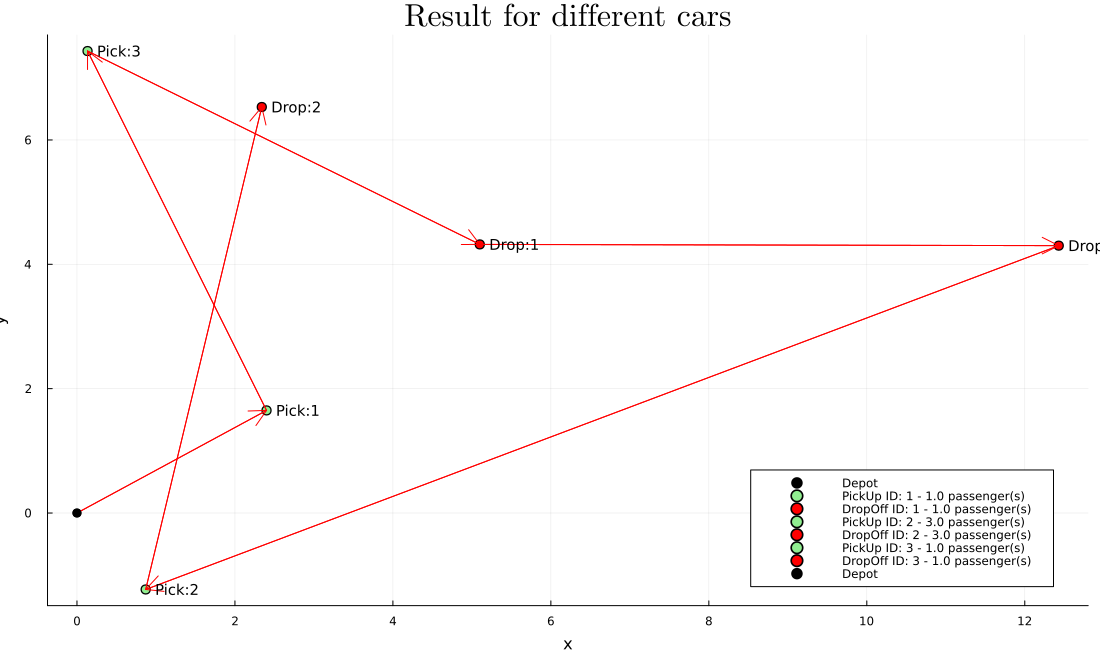

In [11]:
x_values = value.(x)
w_values = round.(Int, value.(w))

plot_route(data, x_values, w_values, [1100, 650])

In [12]:
x_values = round.(Int, value.(x))

8×8×3 Array{Int64, 3}:
[:, :, 1] =
 1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1

[:, :, 2] =
 0  1  0  0  0  0  0  0
 0  0  0  1  0  0  0  0
 0  0  0  0  0  1  0  0
 0  0  0  0  1  0  0  0
 0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  1
 0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0

[:, :, 3] =
 1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1